# Introduction

In this notebook, we provide code for the experiments conducted in the project. For clarity, all the experiments here are done for the dataset of sequences of MNIST imeges. The same experiments may be repeated for any other dataset (Synthetic1D, Human Activity Recognition, Explosion). Moreover, they can repeated be for any other dataset or model presented in the source paper: "InDiD: Instant Disorder Detection via a Principled Neural Network".

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
# necessary imports
from src.metrics.evaluation_pipelines import evaluation_pipeline
from src.ensembles.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel
from src.utils.fix_seeds import fix_seeds

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datetime import datetime
from typing import Any

import yaml

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


# Ensemble model, MNIST dataset

## Initialize and train the model

In [3]:
model_type = "seq2seq"

# choose any dataset you need, i.e. "synthetic_1D", "human_activity", "mnist" or "explosion"
experiments_name = "human_activity"

# read arguments from a default config file for a particular experiment
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

# update args dictionary for con
args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

# choose loss type - 'BCE' in our case
args_config["loss_type"] = "bce"

# number of CPUs available
args_config["num_workers"] = 2

# set args_config["learning"]["gpus"] = 0 for training models on CPU
args_config["learning"]["gpus"] = 1

# number of epochs to train each model in ensemble
args_config["learning"]["epochs"] = 100

In [4]:
# Initialize Ensemble of n_models=10 base models
# boot_sample_size=None indicates training on the full train set
# Otherwise, choose int boot_sample_size to train models on bootstrapped subsamples of the train set
ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)

# fit the models and save the models weights
# ens_bce.fit()
# ens_bce.save_models_list("saved_models/mnist")

# OR load weights of the pre-trained models available
ens_bce.load_models_list("saved_models/bce/human_activity/full_sample/ens_1")

## Visialize random predictions

In [31]:
def visualize_predictions(
    model: Any,
    sequences_batch: torch.Tensor,
    labels_batch: torch.Tensor,
    n_pics: int = 10,
    save_path: str = None,
    scale: int = None,
) -> None:
    """Visualize model's predictions for a batch of test sequences.

    :param model: trained model (e.g. CPDModel or EnsembleCPDModel)
    :param sequences_batch: batch of test sequences
    :param lavels_batch: batch of corresponding labels
    :param n_pics: number of pictures to plot
    :param save: if True, save pictures to the 'pictures' folder
    """
    fontsize = 16

    model.to("cpu")
    sequences_batch = sequences_batch.cpu()
    labels_batch = labels_batch.cpu()

    if len(sequences_batch) < n_pics:
        print("Desired number of pictures is greater than size of the batch provided.")
        n_pics = len(sequences_batch)

    try:
        preds = model(sequences_batch)
    except:
        preds, std = model.predict(sequences_batch, scale=scale)
        std = std.detach().cpu().squeeze()

    preds = preds.detach().cpu().squeeze()

    for idx in range(n_pics):
        if sum(labels_batch[idx]) > 0:
            continue
        plt.figure()
        plt.plot(preds[idx], linewidth=2, label="Ensemble predictions")
        plt.fill_between(
            range(len(preds[idx])),
            preds[idx] - std[idx],
            preds[idx] + std[idx],
            alpha=0.3,
        )
        plt.plot(labels_batch[idx], linewidth=2, label="True labels")
        plt.xlabel("Time", fontsize=fontsize)
        plt.ylabel("CP score", fontsize=fontsize)
        plt.xticks([0, 3, 6, 9, 12, 15, 18], fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        # plt.title("Mean +- std redictions", fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(f"{save_path}/preds_seq_{idx}.pdf")
        plt.show()

In [ ]:
fix_seeds(0)

# create test_dataset and test_dataloader
test_dataset = ens_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))

visualize_predictions(
    ens_bce, seq_batch, labels_batch, n_pics=512, save_path="pictures/predictions"
)

## Compute metrics for the ensemble mean predictions

In [16]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics_local, (_, _), delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cpu",  # choose 'cpu' or 'cuda' if available
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

# if necessary, write metrics to file
"""
metrics.write_metrics_to_file(
    filename="results/results_" + experiments_name + "_" + model_type + "_10_models.txt",
    metrics=metrics_local,
    seed=seed,
    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    comment="MNIST, ensemble mean predictions"
)
"""

Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1306, FN: 0, TP: 31, DELAY:0.0, FP_DELAY:0.052356019616127014, COVER: 0.6693305908750935
TN: 1, FP: 939, FN: 0, TP: 397, DELAY:0.0, FP_DELAY:2.6335079669952393, COVER: 0.7798021087729445
TN: 2, FP: 670, FN: 0, TP: 665, DELAY:0.0, FP_DELAY:5.219895362854004, COVER: 0.8735963463658387
TN: 6, FP: 582, FN: 0, TP: 749, DELAY:0.0, FP_DELAY:5.987285137176514, COVER: 0.9046518215099233
TN: 7, FP: 530, FN: 0, TP: 800, DELAY:0.0, FP_DELAY:6.463724613189697, COVER: 0.9186335070703189
TN: 11, FP: 489, FN: 0, TP: 837, DELAY:0.0, FP_DELAY:6.7531785964965

'\nmetrics.write_metrics_to_file(\n    filename="results/results_" + experiments_name + "_" + model_type + "_10_models.txt",\n    metrics=metrics_local,\n    seed=seed,\n    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),\n    comment="MNIST, ensemble mean predictions"\n)\n'

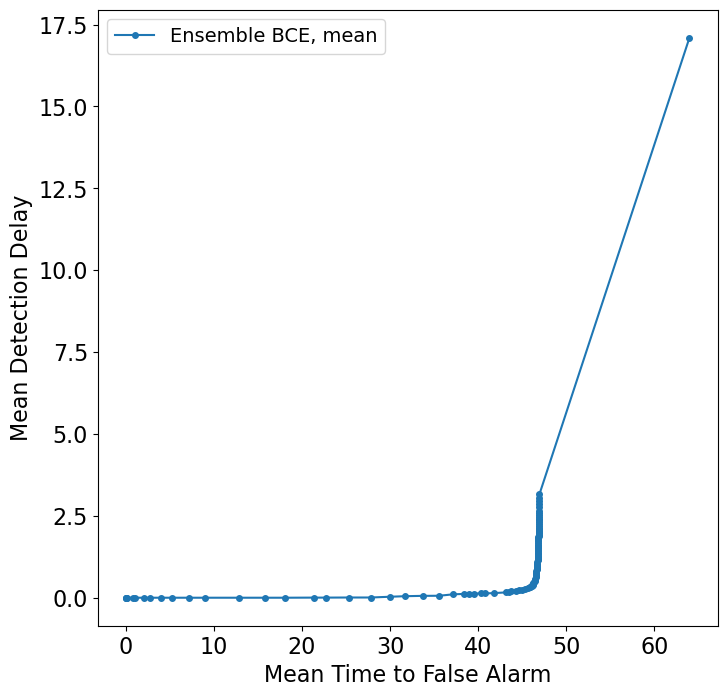

In [10]:
# plot Detection Curve

plt.figure(figsize=(8, 8))
plt.plot(
    fp_delay_list.values(),
    delay_list.values(),
    "-o",
    markersize=4,
    label="Ensemble BCE, mean",
)

plt.xlabel("Mean Time to False Alarm", fontsize=16)
plt.ylabel("Mean Detection Delay", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=14);

## Experiments with quantile-based predictions

In order to obtain not 'mean', but quantile predictions of the ensemble, one only needs pass the corresponding arguments to the 'evaluation_pipeline' function. Note that we use the same (already trained or loaded) Ensemble Model.

In [ ]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# desired probability for a quantile
q = 0.7

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_mnist_bce,
    test_dataloader,
    threshold_list,
    device="cuda",  # choose 'cpu' or 'cuda' if available
    model_type="ensemble_quantile",
    verbose=True,
    q=q,
)

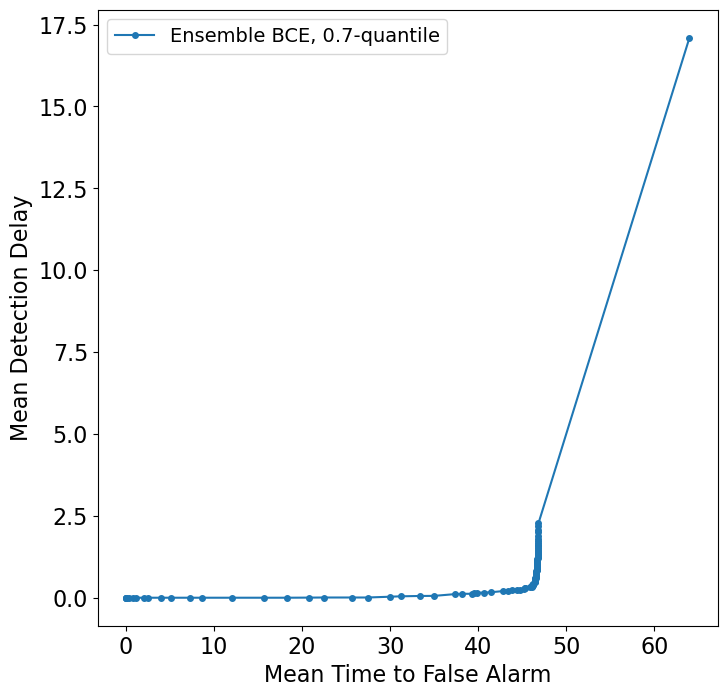

In [14]:
# plot Detection Curve

plt.figure(figsize=(8, 8))
plt.plot(
    fp_delay_list.values(),
    delay_list.values(),
    "-o",
    markersize=4,
    label="Ensemble BCE, 0.7-quantile",
)

plt.xlabel("Mean Time to False Alarm", fontsize=16)
plt.ylabel("Mean Detection Delay", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=14);

## Uncertainty-aware aggregation of CP scores with CUSUM
For this experiments, we have a special 'CusumEnsembleCPDModel' class defined in ensembles.py which has almost the same interface. Note that we do not construct Detection Curves in this experiment.

In [16]:
# choose CUSUM alarm threshold
cusum_threshold = 11.5

# Initialize model and load weights
ens_mnist_bce_susum = CusumEnsembleCPDModel(
    args_config, n_models=10, cusum_threshold=cusum_threshold
)
ens_mnist_bce_susum.load_models_list("saved_models/mnist/full_sample")

# create test_dataset and test_dataloader
test_dataset = ens_mnist_bce_susum.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"]
)

# no need in threshold list for CUSUM-aggregated CP scores
threshold_list = [0.5]

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_mnist_bce_susum,
    test_dataloader,
    threshold_list,
    device="cuda",  # choose 'cpu' or 'cuda' if available
    model_type="cusum_aggr",
    verbose=True,
)

100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]

TN: 158, FP: 9, FN: 9, TP: 124, DELAY:2.8299999237060547, FP_DELAY:47.81999969482422, COVER: 0.9340658676516304
AUC: None
Time to FA 47.82, delay detection 2.83 for best-F1 threshold: 0.5
TN 158, FP 9, FN 9, TP 124 for best-F1 threshold: 0.5
Max F1 0.9323: for best-F1 threshold 0.5
COVER 0.9341: for best-F1 threshold 0.5
Max COVER 0.9341: for threshold 0.5


## CPD with rejection
For this experiment, we use the basic EnsembleCPDModel class as well.

In [18]:
# Initialize Ensemble of n_models=10 base models and load weights
ens_mnist_bce = EnsembleCPDModel(args_config, n_models=10)
ens_mnist_bce.load_models_list("saved_models/mnist/full_sample")

In [ ]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# choose std rejection threshold and provide evaluation_pipeline with this argument
uncert_th = 0.03

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_mnist_bce,
    test_dataloader,
    threshold_list,
    device="cuda",  # choose 'cpu' or 'cuda' if available
    model_type="ensemble",
    verbose=True,
    uncert_th=uncert_th,
)

# KL-CPD Ensembles

## Synthetic 1D

In [8]:
model_type = "kl_cpd"
experiments_name = "synthetic_1D"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2
args_config["learning"]["accelerator"] = "gpu"
args_config["learning"]["devices"] = 1

In [9]:
ens_synth_klcpd = EnsembleCPDModel(args_config, n_models=5, boot_sample_size=None)

test_dataset = ens_synth_klcpd.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"]
)

# ens_synth_klcpd.fit(
#    monitor=args_config["early_stopping"]["monitor"],
#    patience=args_config["early_stopping"]["patience"],
#    min_delta=args_config["early_stopping"]["min_delta"]
# )
# ens_synth_klcpd.save_models_list("saved_models/kl_cpd/synthetic_1D")

ens_synth_klcpd.load_models_list("saved_models/kl_cpd/synthetic_1D/5_models")

KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(1, 4, batch_first=True)
    (fc_layer): Linear(in_features=4, out_features=1, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(4, 1, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(1, 4, batch_first=True)
    (fc_layer): Linear(in_features=4, out_features=1, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(4, 1, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(1, 4, batch_first=True)
    (fc_layer): Linear(in_features=4, out_features=1, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(1, 4, batch_first=True)
    (rnn_dec_layer): GRU(4, 1, batch_first=True)
  )
)
KLCP

Iter


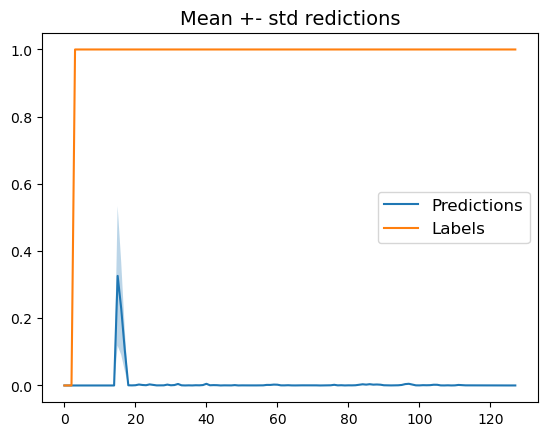

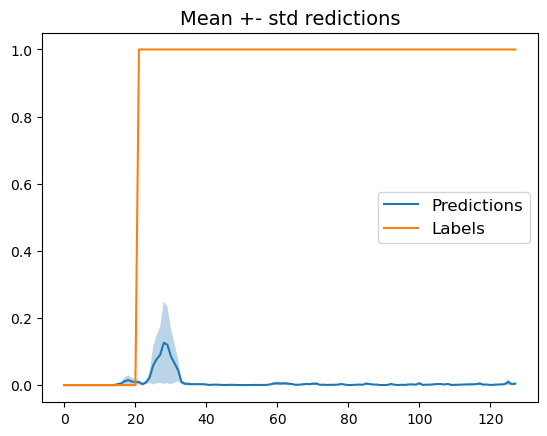

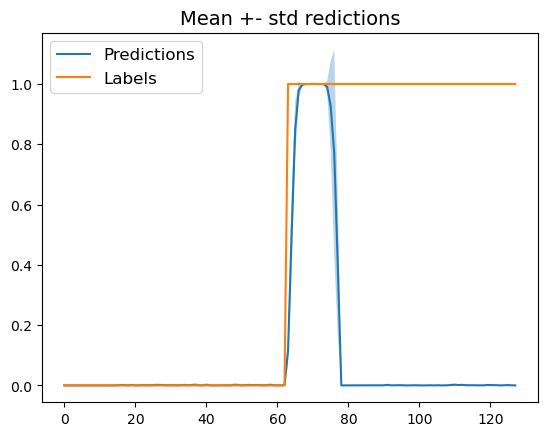

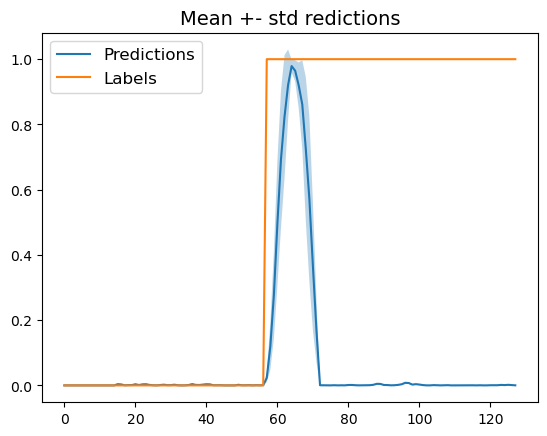

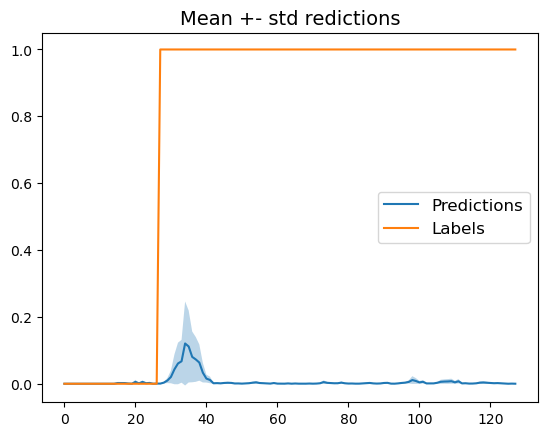

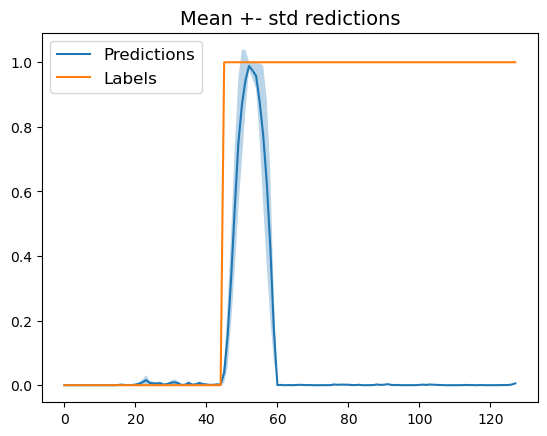

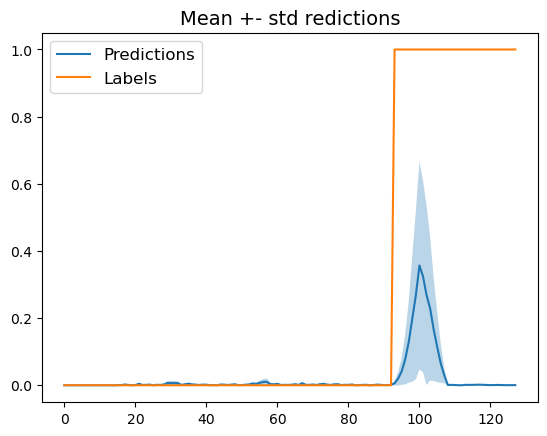

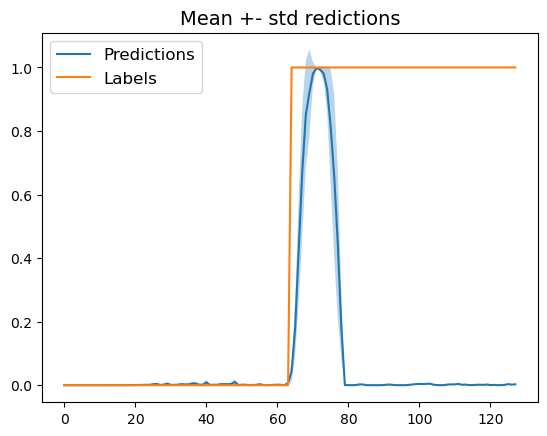

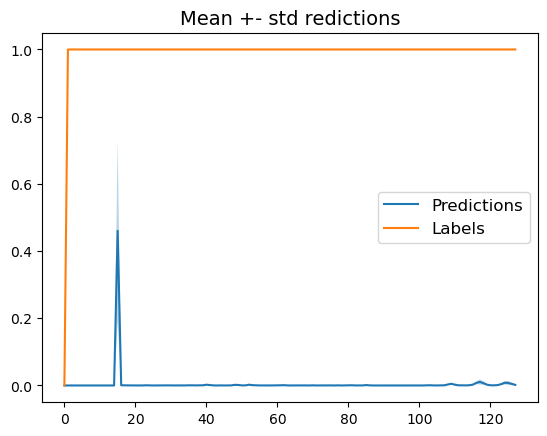

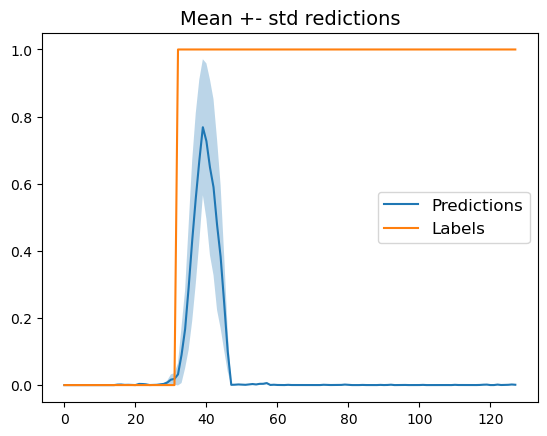

In [16]:
seq_batch, labels_batch = next(iter(test_dataloader))

# save_path = None
save_path = "pictures/kl_cpd/synthetic_1D"

visualize_predictions(
    ens_synth_klcpd, seq_batch, labels_batch, n_pics=10, save_path=save_path, scale=100
)

In [ ]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_synth_klcpd,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    scale=100,
)

# if necessary, write metrics to file
metrics.write_metrics_to_file(
    filename="results/kl_cpd/synthetic_1D/results_"
    + experiments_name
    + "_"
    + model_type
    + "_5_models.txt",
    metrics=metrics_local,
    seed=seed,
    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    comment="MNIST, KL-CPD ensemble mean predictions, 5 models",
)


  0%|                                                                                    | 0/27 [00:00<?, ?it/s]

Iter
Iter
Iter
Iter
Iter
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  4%|██▋                                                                      | 1/27 [13:52<6:00:49, 832.68s/it]

Iter
Iter
Iter
Iter
Iter
TN: 5, FP: 251, FN: 0, TP: 44, DELAY:0.4033333361148834, FP_DELAY:35.393333435058594, COVER: 0.7430336709047022



  7%|█████▍                                                                   | 2/27 [27:24<5:41:51, 820.45s/it]

Iter
Iter


## Human Activity

In [17]:
model_type = "kl_cpd"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2
args_config["learning"]["accelerator"] = "gpu"
args_config["learning"]["devices"] = 1

In [23]:
ens_har_klcpd = EnsembleCPDModel(args_config, n_models=5, boot_sample_size=None)

# ens_har_klcpd.fit(
#    monitor=args_config["early_stopping"]["monitor"],
#    patience=args_config["early_stopping"]["patience"],
#    min_delta=args_config["early_stopping"]["min_delta"]
# )
# ens_har_klcpd.save_models_list("saved_models/kl_cpd/human_activity")

ens_har_klcpd.load_models_list("saved_models/kl_cpd/human_activity")

test_dataset = ens_har_klcpd.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True
)

KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(28, 8, batch_first=True)
    (fc_layer): Linear(in_features=8, out_features=28, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(8, 28, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(28, 8, batch_first=True)
    (fc_layer): Linear(in_features=8, out_features=28, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(8, 28, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(28, 8, batch_first=True)
    (fc_layer): Linear(in_features=8, out_features=28, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(28, 8, batch_first=True)
    (rnn_dec_layer): GRU(8, 28, batch_first=T

Iter


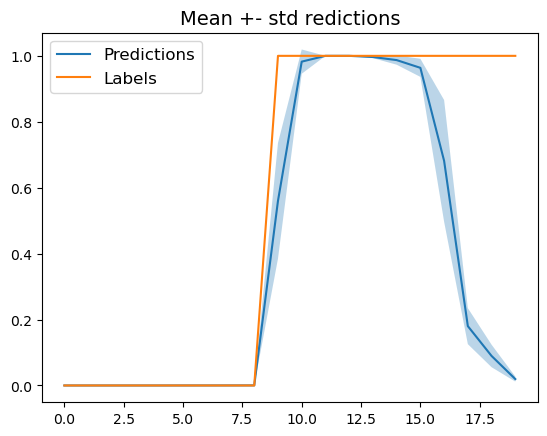

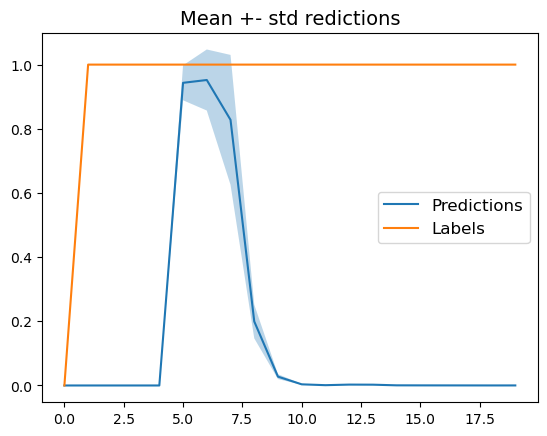

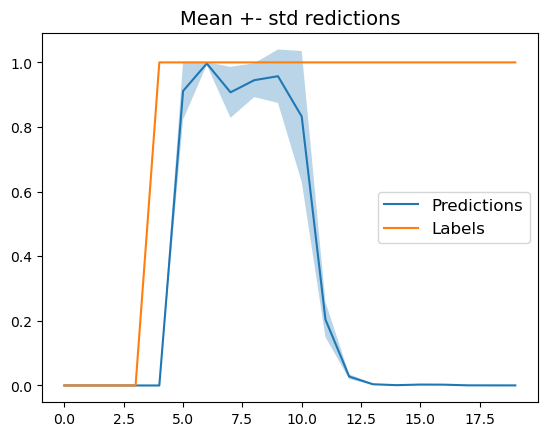

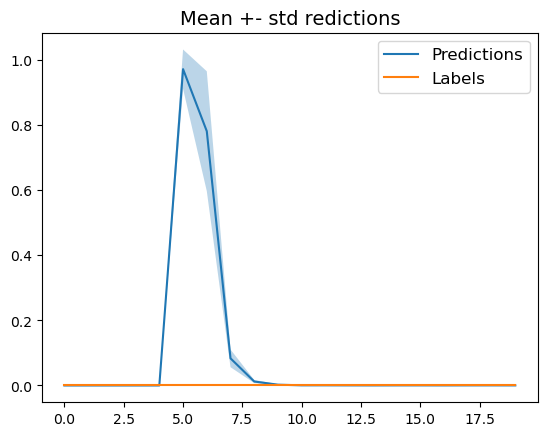

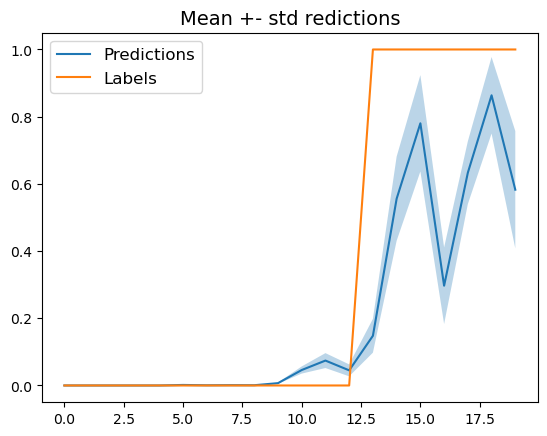

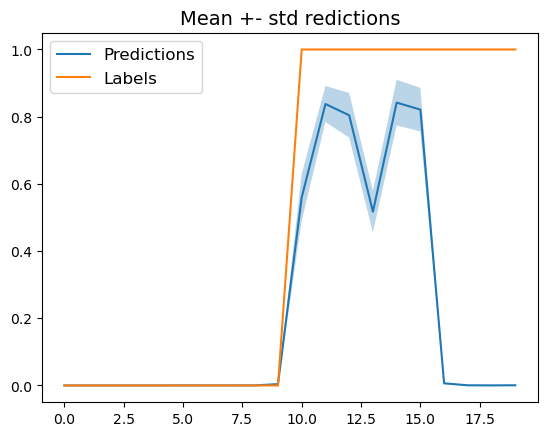

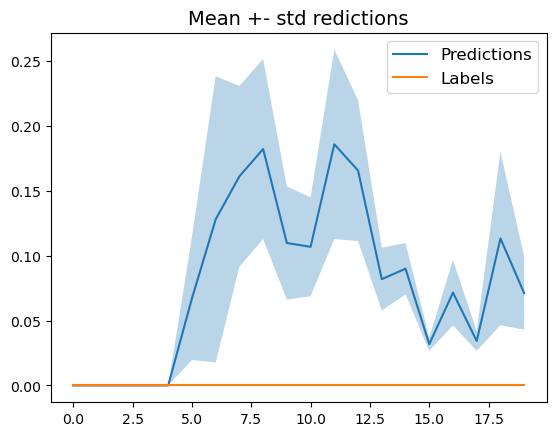

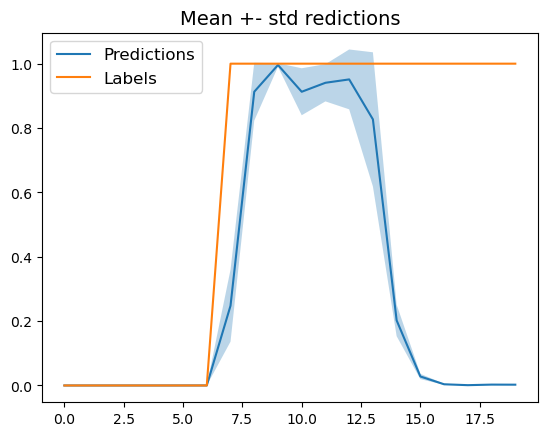

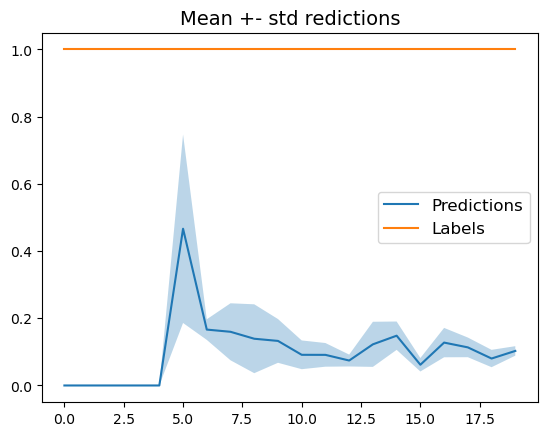

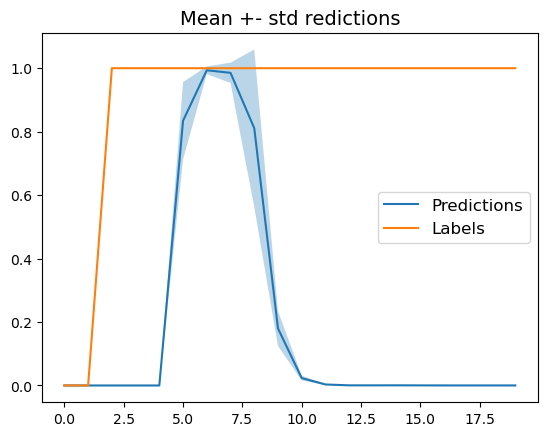

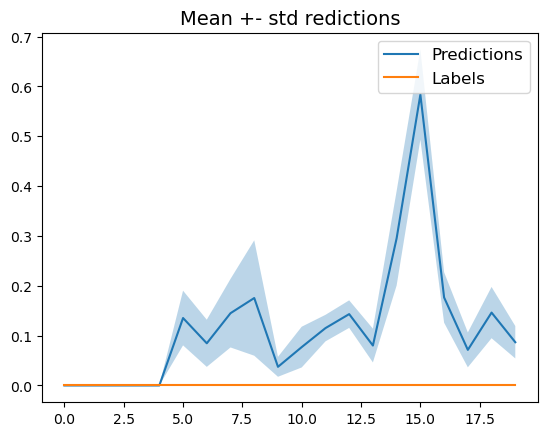

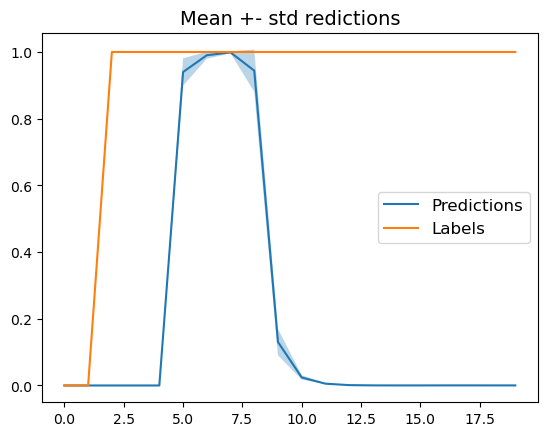

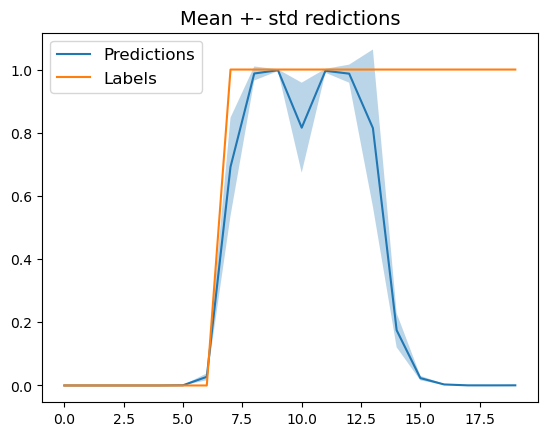

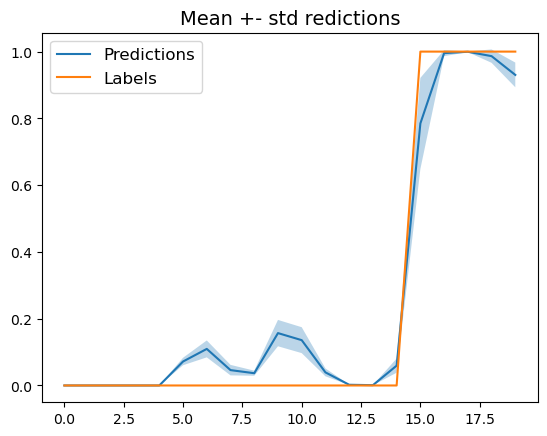

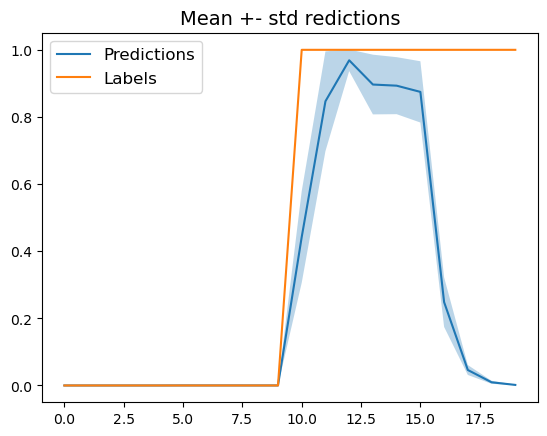

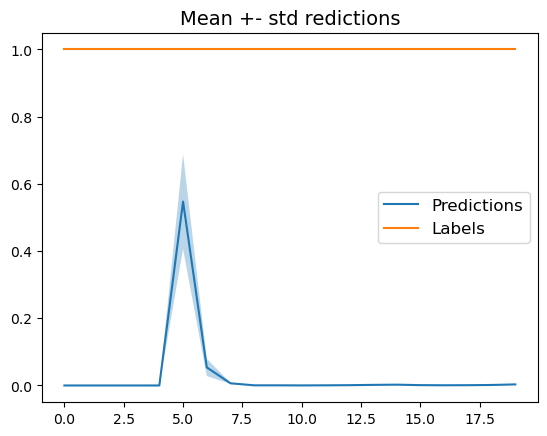

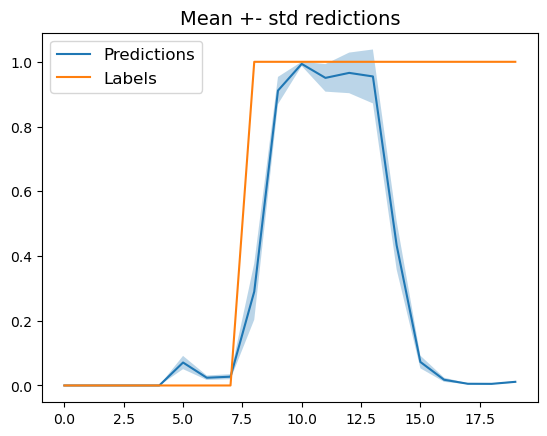

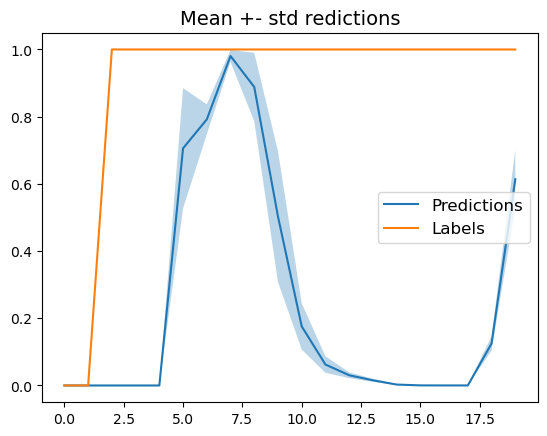

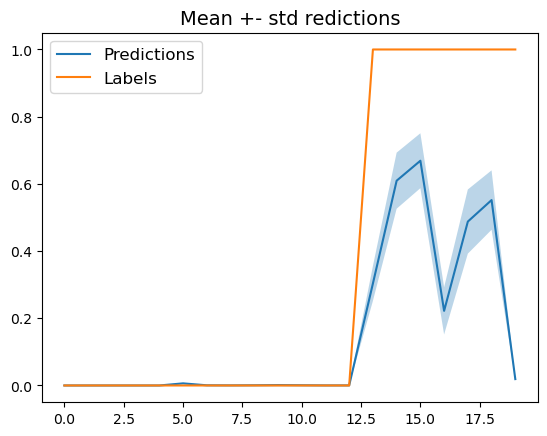

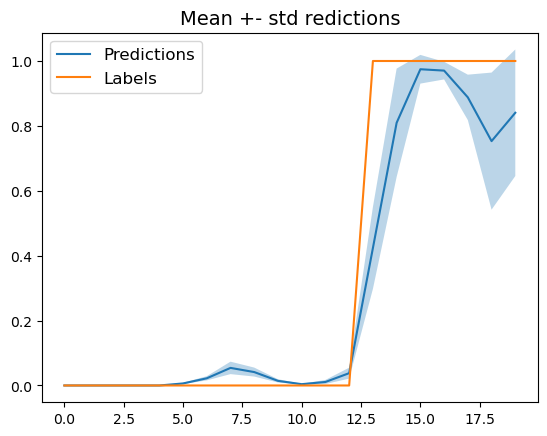

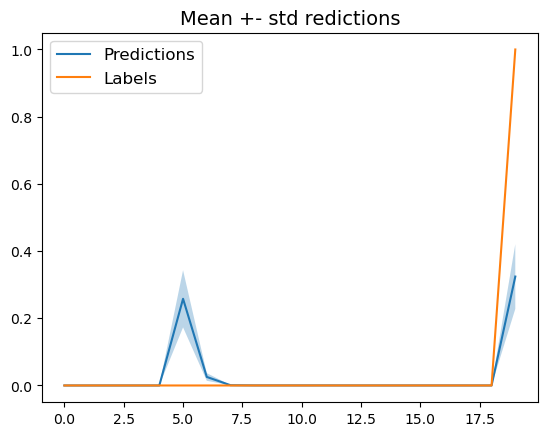

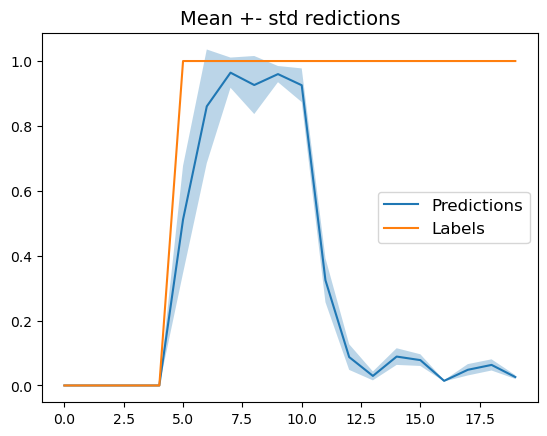

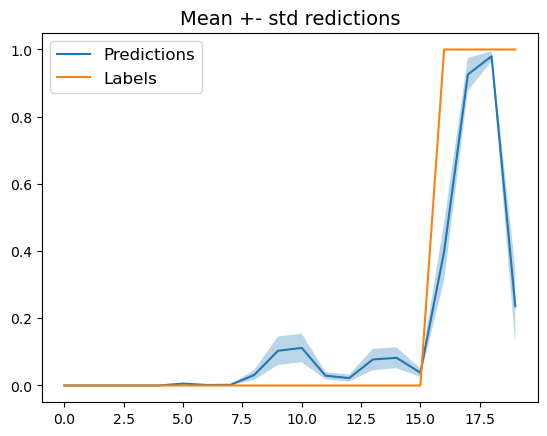

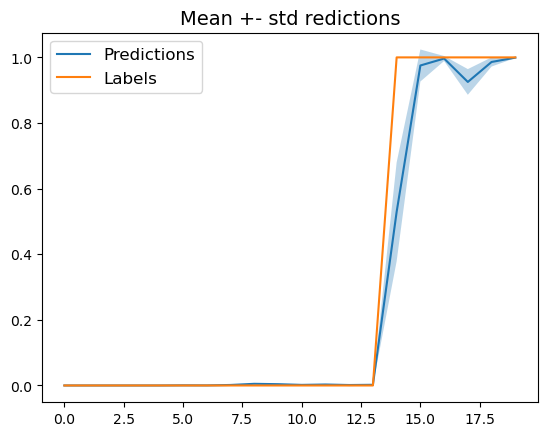

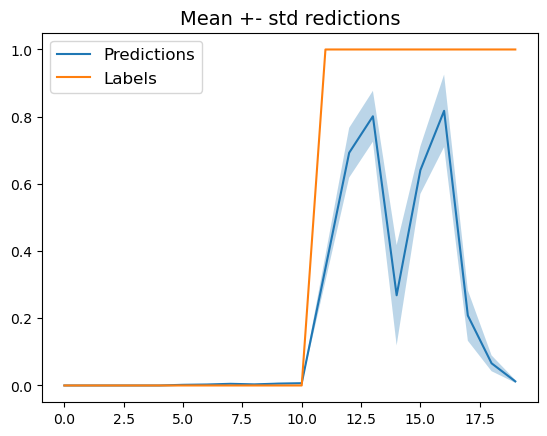

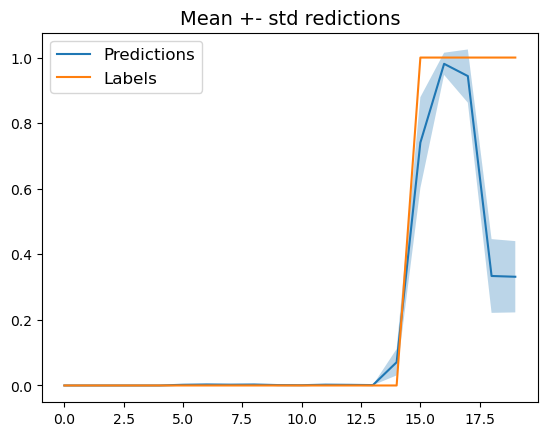

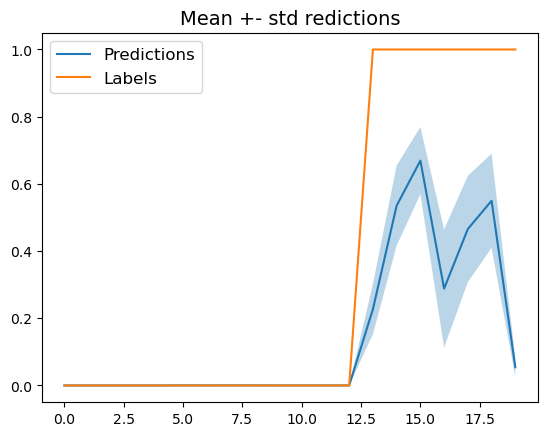

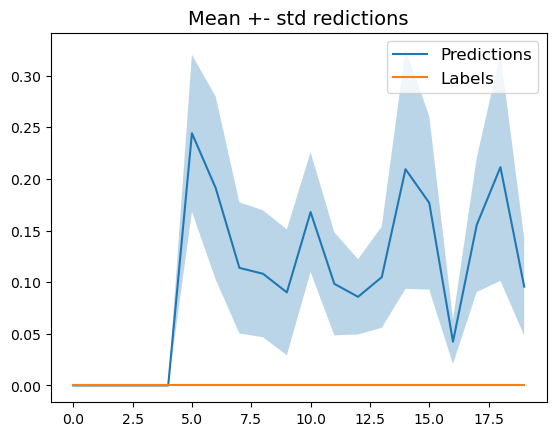

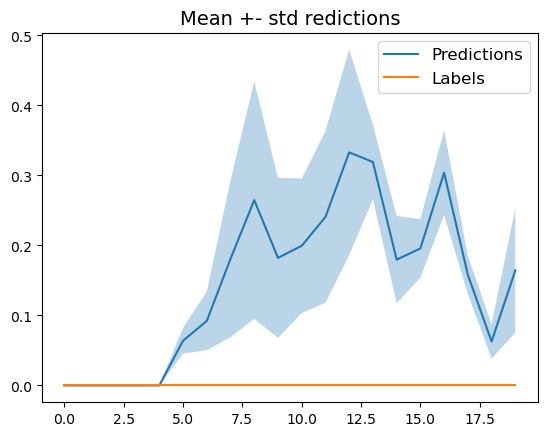

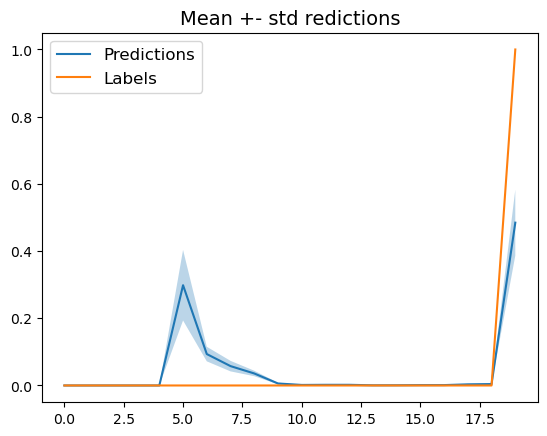

In [25]:
seq_batch, labels_batch = next(iter(test_dataloader))

# save_path = None
save_path = "pictures/kl_cpd/human_activity"

visualize_predictions(
    ens_har_klcpd, seq_batch, labels_batch, n_pics=30, save_path=save_path, scale=5
)

In [ ]:
test_dataset = ens_har_klcpd.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"]
)

threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_har_klcpd,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    scale=5,
)

# if necessary, write metrics to file
metrics.write_metrics_to_file(
    filename="results/kl_cpd/human_activity/results_"
    + experiments_name
    + "_"
    + model_type
    + "_10_models.txt",
    metrics=metrics_local,
    seed=seed,
    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    comment="MNIST, KL-CPD ensemble mean predictions, 10 models",
)

## MNIST

In [3]:
model_type = "kl_cpd"
experiments_name = "mnist"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2
args_config["learning"]["accelerator"] = "gpu"
args_config["learning"]["devices"] = 1

In [4]:
ens_mnist_klcpd = EnsembleCPDModel(args_config, n_models=5, boot_sample_size=None)

# ens_mnist_klcpd.fit(
#    monitor=args_config["early_stopping"]["monitor"], patience=args_config["early_stopping"]["patience"]
# )
# ens_mnist_klcpd.save_models_list("saved_models/kl_cpd/mnist")

ens_mnist_klcpd.load_models_list("saved_models/kl_cpd/mnist/5_models")

test_dataset = ens_mnist_klcpd.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True
)

KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_layer): GRU(784, 32, batch_first=True)
    (fc_layer): Linear(in_features=32, out_features=784, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_layer): GRU(32, 784, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_layer): GRU(784, 32, batch_first=True)
    (fc_layer): Linear(in_features=32, out_features=784, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_layer): GRU(32, 784, batch_first=True)
  )
)
KLCPD(
  (net_generator): NetG(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_layer): GRU(784, 32, batch_first=True)
    (fc_layer): Linear(in_features=32, out_features=784, bias=True)
  )
  (net_discriminator): NetD(
    (rnn_enc_layer): GRU(784, 32, batch_first=True)
    (rnn_dec_laye

Iter


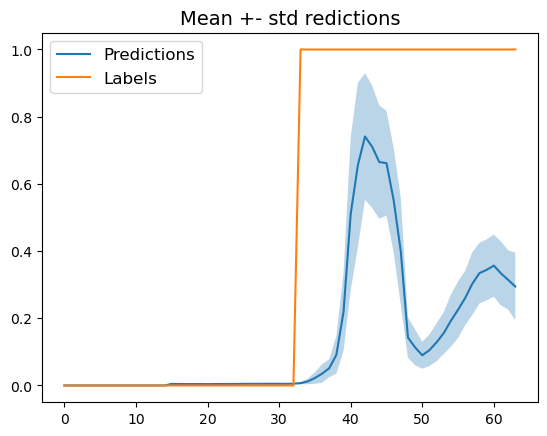

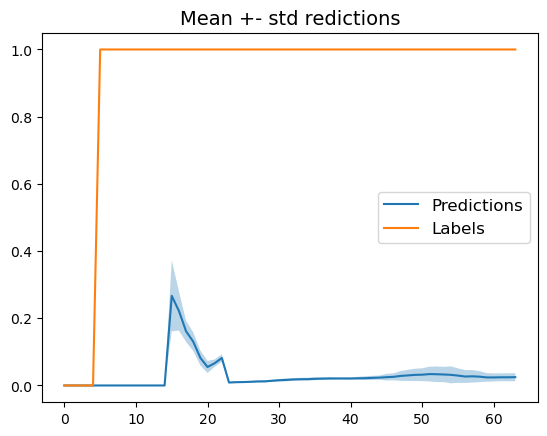

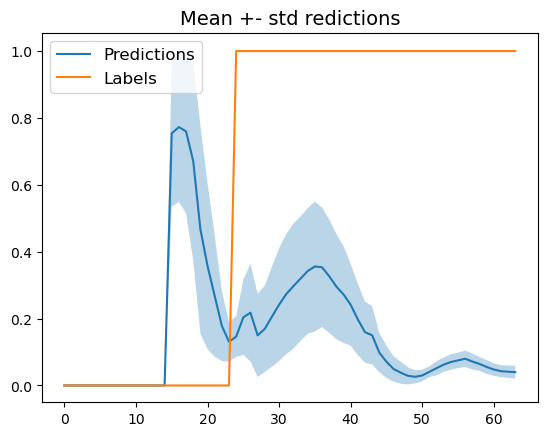

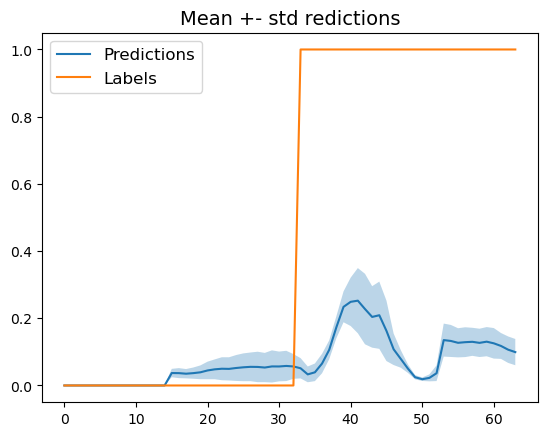

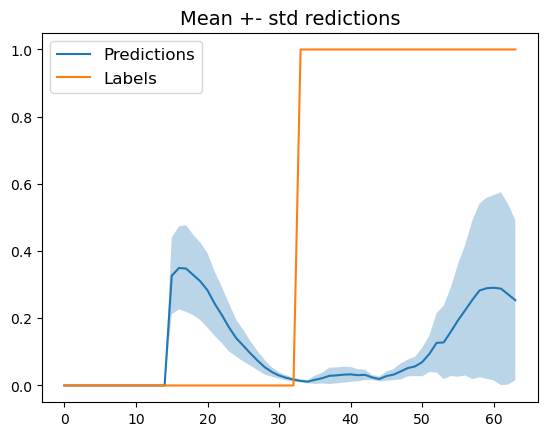

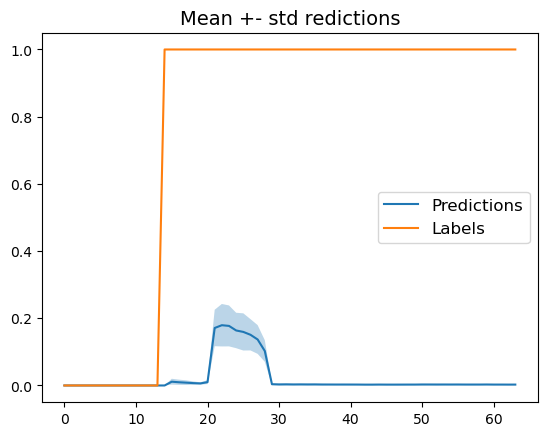

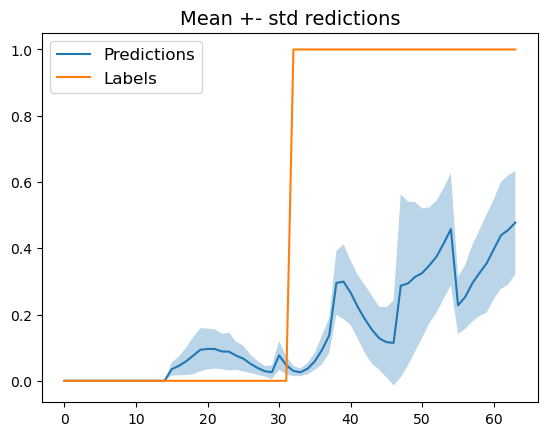

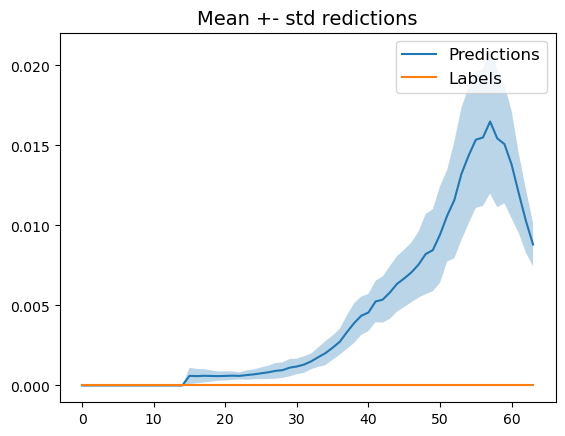

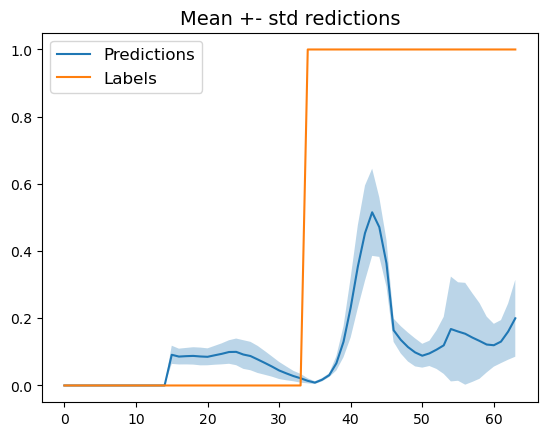

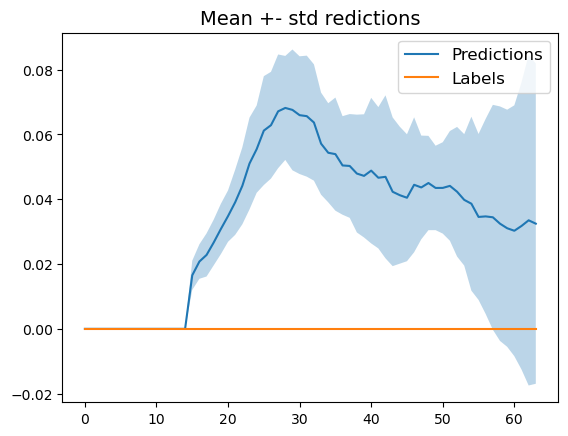

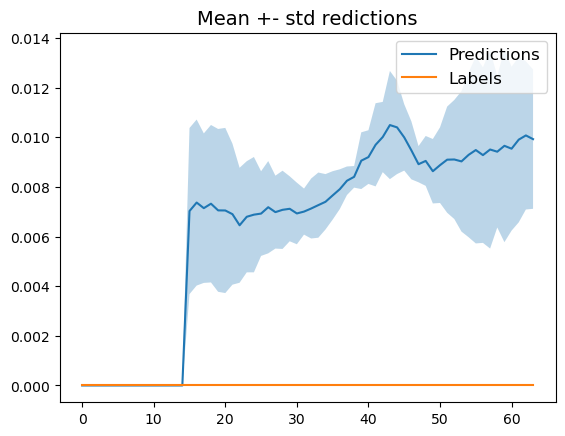

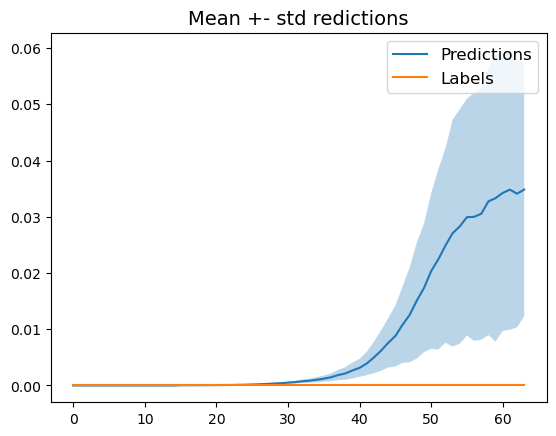

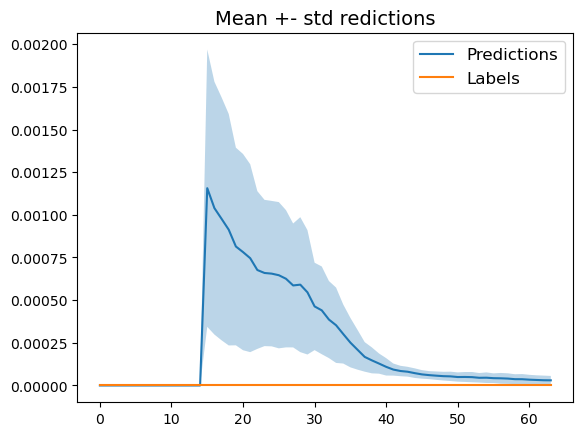

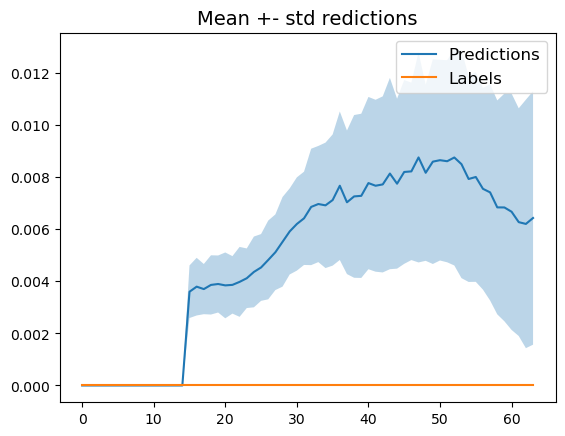

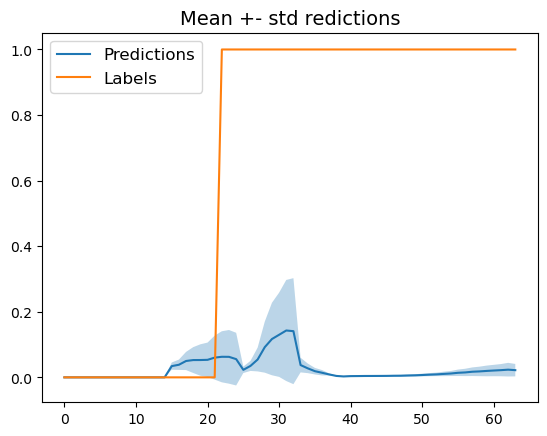

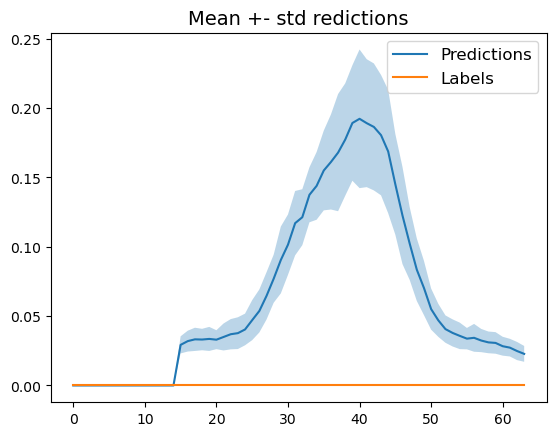

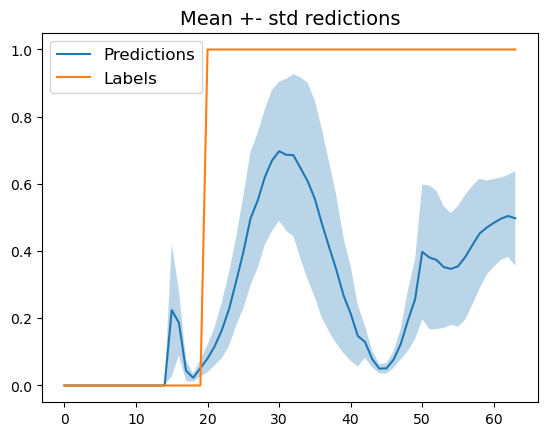

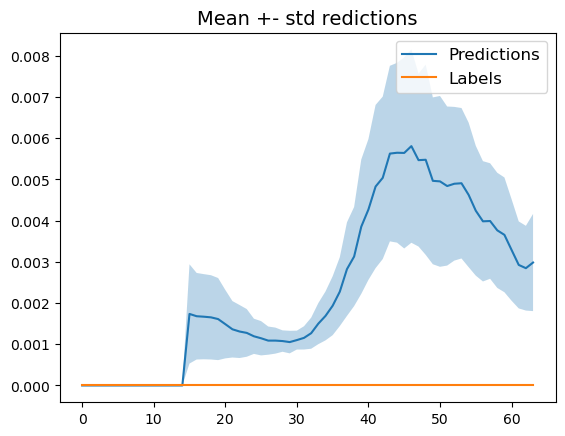

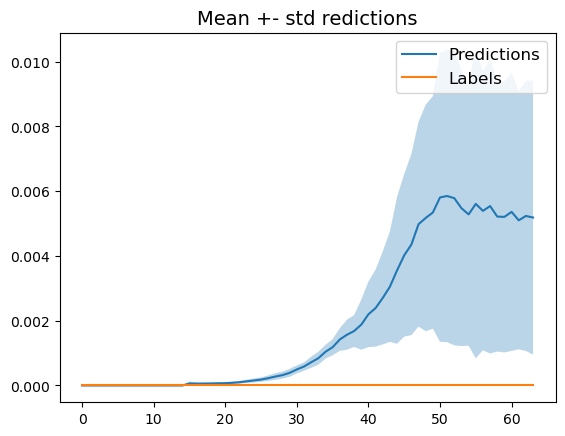

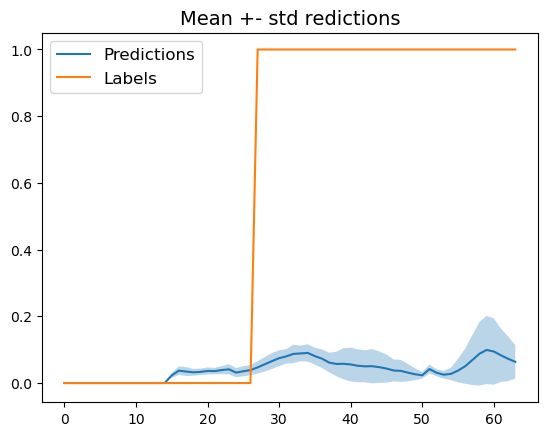

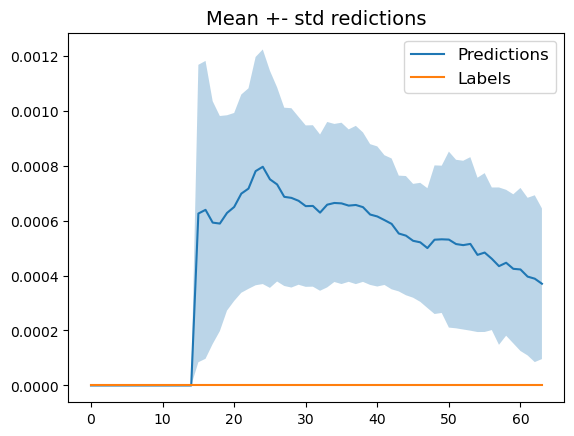

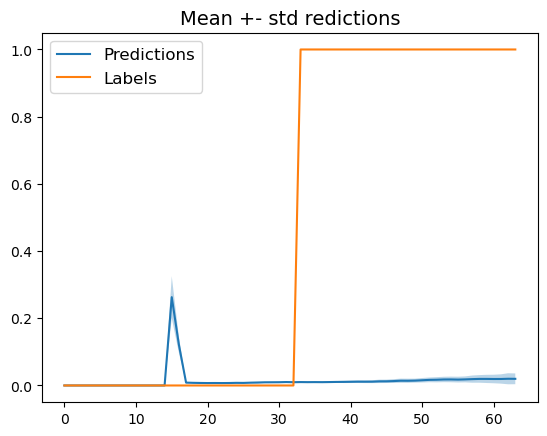

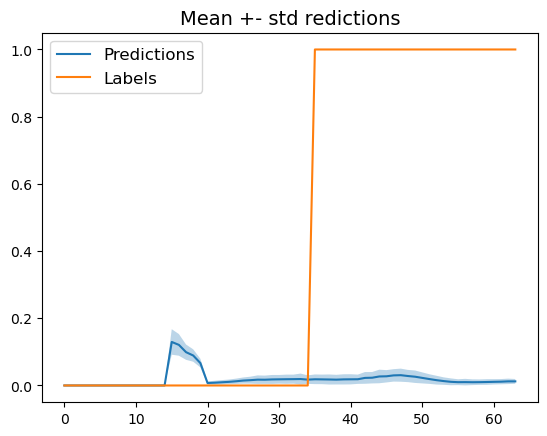

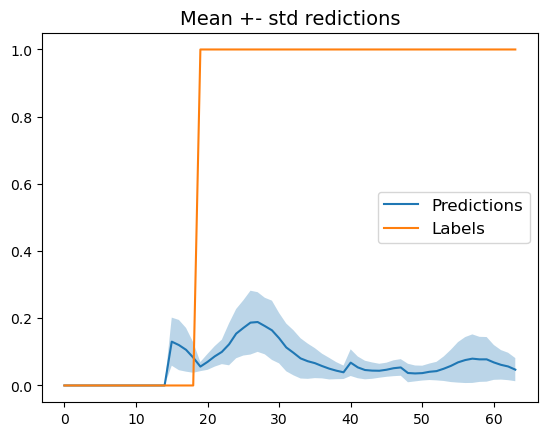

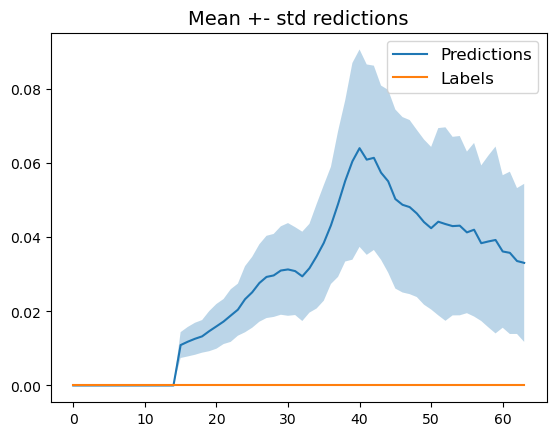

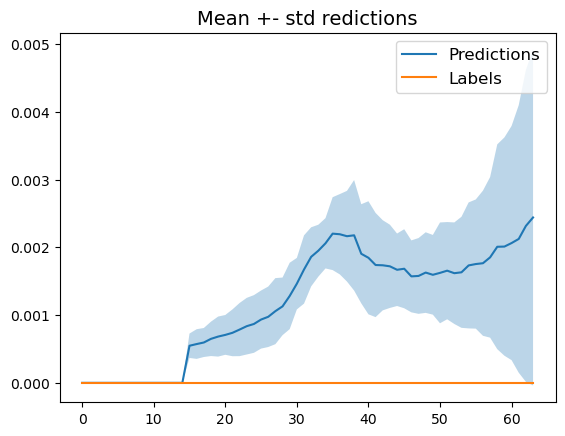

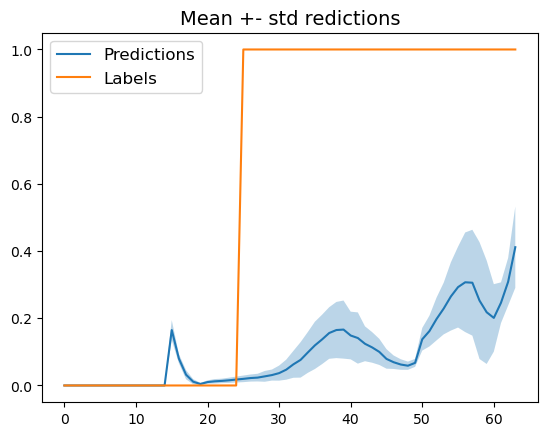

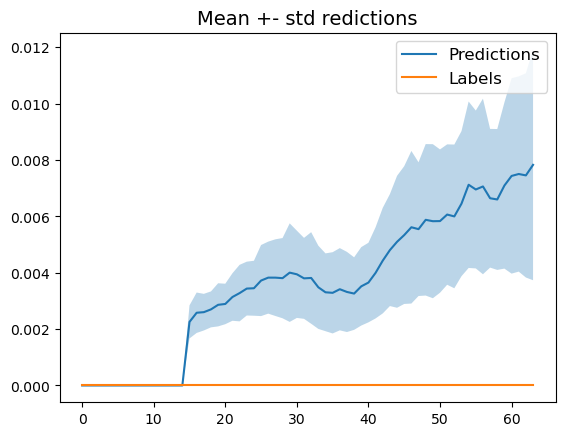

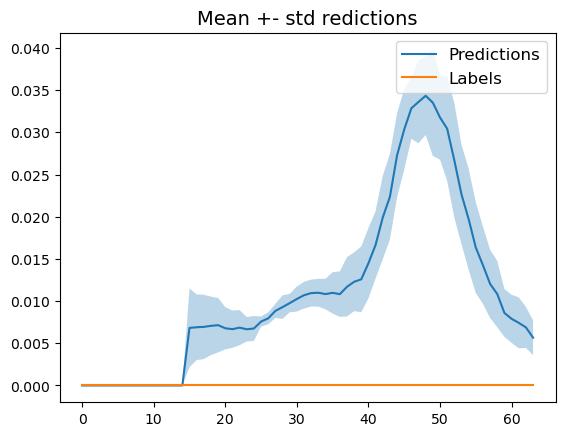

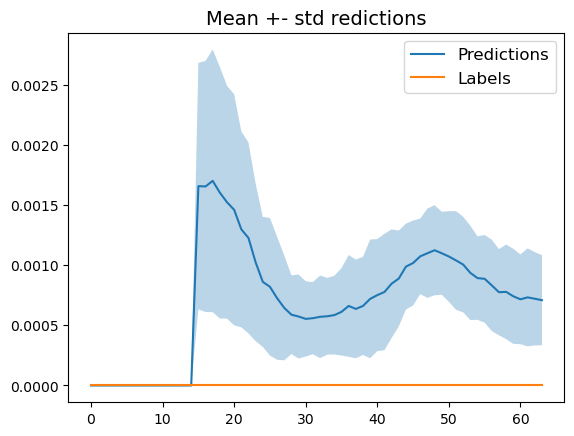

In [8]:
seq_batch, labels_batch = next(iter(test_dataloader))

# save_path = None
save_path = "pictures/kl_cpd/mnist"

visualize_predictions(
    ens_mnist_klcpd, seq_batch, labels_batch, n_pics=30, save_path=save_path, scale=100
)

In [16]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics_local, delay_list, fp_delay_list = metrics.evaluation_pipeline(
    ens_mnist_klcpd,
    test_dataloader,
    threshold_list,
    device="cuda",  # choose 'cpu' or 'cuda' if available
    model_type="ensemble",
    verbose=True,
    scale=100,  # for MNIST experiments
)

# if necessary, write metrics to file
metrics.write_metrics_to_file(
    filename="results/kl_cpd/mnist/results_"
    + experiments_name
    + "_"
    + model_type
    + "_5_models.txt",
    metrics=metrics_local,
    seed=seed,
    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    comment="MNIST, KL-CPD ensemble mean predictions, 5 models",
)


  0%|                                                                                    | 0/27 [00:00<?, ?it/s]

Iter
Iter
Iter
Iter
Iter
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625



  4%|██▋                                                                     | 1/27 [17:46<7:41:59, 1066.14s/it]

Iter
Iter
Iter
Iter
Iter
TN: 74, FP: 200, FN: 1, TP: 25, DELAY:0.38999998569488525, FP_DELAY:30.803333282470703, COVER: 0.7676733469935086



  7%|█████▎                                                                  | 2/27 [34:56<7:15:30, 1045.21s/it]

Iter
Iter
Iter
Iter
Iter
TN: 91, FP: 178, FN: 1, TP: 30, DELAY:0.5099999904632568, FP_DELAY:33.766666412353516, COVER: 0.7910834201511302



 11%|████████                                                                | 3/27 [52:13<6:56:27, 1041.17s/it]

Iter
Iter
Iter
Iter
Iter
TN: 106, FP: 157, FN: 2, TP: 35, DELAY:0.7833333611488342, FP_DELAY:36.51333236694336, COVER: 0.8115554068799162



 15%|██████████▎                                                           | 4/27 [1:09:12<6:35:51, 1032.68s/it]

Iter
Iter
Iter
Iter
Iter
TN: 121, FP: 137, FN: 2, TP: 40, DELAY:0.9333333373069763, FP_DELAY:38.83000183105469, COVER: 0.8271366163109853



 19%|████████████▉                                                         | 5/27 [1:26:35<6:19:57, 1036.26s/it]

Iter
Iter
Iter
Iter
Iter
TN: 129, FP: 118, FN: 4, TP: 49, DELAY:1.5, FP_DELAY:40.599998474121094, COVER: 0.8370901077925107



 22%|███████████████▌                                                      | 6/27 [1:43:39<6:01:17, 1032.25s/it]

Iter
Iter
Iter
Iter
Iter
TN: 140, FP: 97, FN: 8, TP: 55, DELAY:2.013333320617676, FP_DELAY:42.38999938964844, COVER: 0.8509679497885106



 26%|██████████████████▏                                                   | 7/27 [2:00:57<5:44:40, 1034.00s/it]

Iter
Iter
Iter
Iter
Iter
TN: 146, FP: 80, FN: 15, TP: 59, DELAY:3.493333339691162, FP_DELAY:44.47666549682617, COVER: 0.8523713909899407



 30%|████████████████████▋                                                 | 8/27 [2:18:18<5:28:11, 1036.41s/it]

Iter
Iter
Iter
Iter
Iter
TN: 149, FP: 59, FN: 27, TP: 65, DELAY:5.25, FP_DELAY:46.91666793823242, COVER: 0.8477856324142717



 33%|███████████████████████▎                                              | 9/27 [2:35:34<5:10:51, 1036.18s/it]

Iter
Iter
Iter
Iter
Iter
TN: 154, FP: 37, FN: 47, TP: 62, DELAY:7.056666851043701, FP_DELAY:50.07666778564453, COVER: 0.8434847037901358



 37%|█████████████████████████▌                                           | 10/27 [2:52:58<4:54:15, 1038.55s/it]

Iter
Iter
Iter
Iter
Iter
TN: 156, FP: 27, FN: 58, TP: 59, DELAY:8.756667137145996, FP_DELAY:52.063331604003906, COVER: 0.8342708105161817



 41%|████████████████████████████                                         | 11/27 [3:10:22<4:37:23, 1040.23s/it]

Iter
Iter
Iter
Iter
Iter
TN: 156, FP: 19, FN: 76, TP: 49, DELAY:10.710000038146973, FP_DELAY:54.65666580200195, COVER: 0.8249186879995258



 44%|██████████████████████████████▋                                      | 12/27 [3:27:56<4:21:04, 1044.28s/it]

Iter
Iter
Iter
Iter
Iter
TN: 157, FP: 10, FN: 88, TP: 45, DELAY:12.15999984741211, FP_DELAY:56.586666107177734, COVER: 0.8183991675744388



 48%|█████████████████████████████████▏                                   | 13/27 [3:45:28<4:04:14, 1046.73s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 8, FN: 97, TP: 37, DELAY:12.59333324432373, FP_DELAY:57.810001373291016, COVER: 0.8166036392629589



 52%|███████████████████████████████████▊                                 | 14/27 [4:02:45<3:46:10, 1043.86s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 6, FN: 107, TP: 29, DELAY:13.579999923706055, FP_DELAY:59.233333587646484, COVER: 0.8104888871398445



 56%|██████████████████████████████████████▎                              | 15/27 [4:20:26<3:29:46, 1048.85s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 5, FN: 116, TP: 21, DELAY:14.616666793823242, FP_DELAY:60.46333312988281, COVER: 0.8023070436080486



 59%|████████████████████████████████████████▉                            | 16/27 [4:37:55<3:12:19, 1049.03s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 1, FN: 127, TP: 14, DELAY:15.666666984558105, FP_DELAY:62.04666519165039, COVER: 0.7976013307430685



 63%|███████████████████████████████████████████▍                         | 17/27 [4:56:01<2:56:42, 1060.23s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 1, FN: 129, TP: 12, DELAY:15.90999984741211, FP_DELAY:62.32666778564453, COVER: 0.7959403927514294



 67%|██████████████████████████████████████████████                       | 18/27 [5:13:38<2:38:51, 1059.05s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 1, FN: 131, TP: 10, DELAY:16.1733341217041, FP_DELAY:62.62333297729492, COVER: 0.7940179490772717



 70%|████████████████████████████████████████████████▌                    | 19/27 [5:45:40<2:55:47, 1318.45s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 1, FN: 133, TP: 8, DELAY:16.33333396911621, FP_DELAY:62.92333221435547, COVER: 0.7934996628457931



 74%|███████████████████████████████████████████████████                  | 20/27 [6:19:47<2:59:19, 1537.09s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 135, TP: 7, DELAY:16.513334274291992, FP_DELAY:63.176666259765625, COVER: 0.7921366712636919



 78%|█████████████████████████████████████████████████████▋               | 21/27 [6:46:15<2:35:13, 1552.31s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 137, TP: 5, DELAY:16.72333335876465, FP_DELAY:63.45000076293945, COVER: 0.7905132373512812



 81%|████████████████████████████████████████████████████████▏            | 22/27 [7:02:23<1:54:44, 1376.98s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 138, TP: 4, DELAY:16.793333053588867, FP_DELAY:63.54999923706055, COVER: 0.7897921702080231



 85%|██████████████████████████████████████████████████████████▊          | 23/27 [7:19:36<1:24:55, 1273.92s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 138, TP: 4, DELAY:16.796667098999023, FP_DELAY:63.54999923706055, COVER: 0.7897036935294729



 89%|███████████████████████████████████████████████████████████████        | 24/27 [7:36:42<59:58, 1199.45s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 138, TP: 4, DELAY:16.799999237060547, FP_DELAY:63.54999923706055, COVER: 0.7896176595788555



 93%|█████████████████████████████████████████████████████████████████▋     | 25/27 [7:54:12<38:29, 1154.66s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 138, TP: 4, DELAY:16.80666732788086, FP_DELAY:63.54999923706055, COVER: 0.7895460008560662



 96%|████████████████████████████████████████████████████████████████████▎  | 26/27 [8:11:21<18:36, 1116.79s/it]

Iter
Iter
Iter
Iter
Iter
TN: 158, FP: 0, FN: 142, TP: 0, DELAY:17.09666633605957, FP_DELAY:64.0, COVER: 0.7872509765625


100%|███████████████████████████████████████████████████████████████████████| 27/27 [8:28:40<00:00, 1130.38s/it]

AUC: 222.4242
Time to FA 46.9167, delay detection 5.25 for best-F1 threshold: 0.1107
TN 149, FP 59, FN 27, TP 65 for best-F1 threshold: 0.1107
Max F1 0.6019: for best-F1 threshold 0.1107
COVER 0.8478: for best-F1 threshold 0.1107
Max COVER 0.8524: for threshold 0.0759
